# Библиотеки для решения задачи

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

def binomial_coeff(n):
    return (n**2 + n)//2

# Прямоугльная область решения задачи

In [478]:
def make_grid(N, L, center, **kwargs):
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор
    grid_mesh = np.stack(np.meshgrid(x,y,z), axis=-1)
    #grid = np.stack([grid_mesh[1], grid_mesh[0], grid_mesh[2]], axis=-1)
    grid = grid_mesh.reshape(-1, 3)
    
    return grid, volume

# Вспомогательная программа для определения индекса рефракции

In [479]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0])) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0])) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0])) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Определение ядра интегрального оператора

In [480]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

# Функция внешней плоской волны 

In [481]:
def wave(x, k=1, orient=[1.0, 1.0, 1.0], sign=1, amplitude=1.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    return amplitude * np.exp(sign * 1j * k * (x.dot(orient)))

# Функция быстрого умножения тензора на вектор

In [482]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), :m, (k + 1):(2 * k)] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """
    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

# Функция действия оператора

In [509]:
def operator(operator_array, vector_array, nu, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    vec_array = nu * vector_array
    result = fast_bbtmv_mul(operator_array.reshape(n_1, n_2, n_3),
                            operator_array.reshape(n_1, n_2, n_3),
                            vec_array.reshape((n_1, n_2, n_3)),
                            n_1, n_2, n_3).reshape(-1,)
    result = vector_array - result
    return result

def conj_operator(conj_operator, vector_array, nu, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    result = np.conj(nu) * fast_bbtmv_mul(conj_operator.reshape(n_1, n_2, n_3), 
                                          conj_operator.reshape(n_1, n_2, n_3), 
                                          vector_array.reshape((n_1, n_2, n_3)), 
                                          n_1, n_2, n_3).reshape(-1,)
    result = vector_array - result
    return result

# Метод минимальных невязок

In [512]:
def gmres(A, b, eta, n_1, n_2, n_3, x0=None, tol=1e-8, max_iter=None):
    # Если число максимально допустимых итераций не задано,
    # присваиваем ему n
    if max_iter is None:
        max_iter = 1000
    
    # Начальное приближение x0 = 0
    if x0 is None:
        x = np.zeros((n_1*n_2*n_3), dtype=A.dtype)
    
    # Начальный вектор невязки r0 = b - A*x0 = b
    r0 = b - operator(A, b, eta, n_1, n_2, n_3)
    
    # Норма начальной невязки
    beta = np.linalg.norm(r0)
    if beta < tol:
        # Начальный вектор уже даёт решение
        return x, 0
    
    # Массив для хранения ортонормированных векторов базиса Крылова
    # V будет иметь размерность (n, max_iter+1)
    V = np.zeros((n_1 * n_2 * n_3, max_iter+1), dtype=A.dtype)
    # Верхне-гауссова матрица Хессенберга H (размерностью (max_iter+1, max_iter))
    H = np.zeros((max_iter+1, max_iter), dtype=A.dtype)
    
    # Первый единичный вектор v1 = r0 / ||r0||
    V[:, 0] = r0 / beta
    
    # Вектор g, который будет хранить величины (beta, 0, 0, ...)
    g = np.zeros(max_iter+1, dtype=A.dtype)
    g[0] = beta
    
    # Переменные для хранения текущей итерации и фактора вращения (Givens rotations)
    cs = np.zeros(max_iter+1, dtype=A.dtype)  # косинусы
    sn = np.zeros(max_iter+1, dtype=A.dtype)  # синусы
    
    # Основной цикл итераций GMRES
    for k in range(max_iter):
        # 1. Вычисляем w = A * v_k
        w = operator(A, V[:, k], eta, n_1, n_2, n_3)
        
        # 2. Ортогонализируем w относительно всех предыдущих v_j (j=1..k)
        for j in range(k+1):
            H[j, k] = np.vdot(V[:, j].reshape(-1, ), w.reshape(-1, ))
            w -= H[j, k] * V[:, j]
        
        # 3. Норма вектора w
        H[k+1, k] = np.linalg.norm(w)
        
        # Если норма w практически 0, завершаем итерации
        if abs(H[k+1, k]) < 1e-15:
            # Решаем маленькую систему
            y = np.linalg.lstsq(H[:k+1, :k+1], g[:k+1], rcond=None)[0]
            x = x + np.dot(V[:, :k+1], np.conj(y))
            return x, 0  # решение найдено досрочно
        
        # 4. Нормируем w и добавляем в список ортонормированных векторов
        V[:,k+1] = w / H[k+1, k]
        
        # 5. Применяем вращения (Givens rotations), чтобы превратить H в верхнюю треугольную
        for i in range(k):
            # Сохраняем старые значения для обновления
            temp = cs[i]*H[i, k] + sn[i]*H[i+1, k]
            H[i+1, k] = -sn[i]*H[i, k] + cs[i]*H[i+1, k]
            H[i, k] = temp
        
        # 6. Вычисляем новые значения cs[k], sn[k] для зануления H[k+1, k]
        r = np.hypot(H[k, k].real, H[k+1, k].real)
        cs[k] = H[k, k] / r
        sn[k] = -H[k+1, k] / r
        H[k, k] = cs[k]*H[k, k] - sn[k]*H[k+1, k]
        H[k+1, k] = 0.0
        
        # 7. Обновляем вектор g
        temp = cs[k]*g[k] - sn[k]*g[k+1]
        g[k+1] = sn[k]*g[k] + cs[k]*g[k+1]
        g[k] = temp
        
        # 8. Проверяем невязку по текущему значению g[k+1]
        resid = abs(g[k+1])
        print(f"Итерация №{k+1}: умножений М-В L = {k+1},\n умножений В-В V = {binomial_coeff(k+1)},\n невязка resid = {round(resid, 8)}\n")
        if resid < tol:
            # Находим решение через малую систему H и g
            y = np.linalg.lstsq(H[:k+1, :k+1], g[:k+1], rcond=None)[0]
            x = x + np.dot(V[:, :k+1], np.conj(y))        
            return x, 0  # решение найдено с нужной точностью
    
    # Если мы дошли до max_iter итераций, считаем, что решение не достигло tol
    # Решение на данном шаге:
    y = np.linalg.lstsq(H[:max_iter, :max_iter], g[:max_iter], rcond=None)[0]
    x = x + np.dot(V[:, :max_iter],np.conj(y))
    return x, k

# Стабилизированный метод бисопряженных градиентов

In [513]:
def bicg_norm(x):
    return np.sqrt(np.sum(x * np.conj(x)))

def bicg_ldot(x, y):
    return np.sum(np.conj(x) * y)

def bicg_rdot(x, y):
    return np.sum(x * np.conj(y))

def bicgstab(prep_fourier_oper, vector_f, vector_nu, vector_u0=None, n_1=20, n_2=20, n_3=20, tol=1e-8, max_iter=1000):
    """
    """
    if vector_u0 is None:
        vector_u0 = np.zeros(vector_f.shape) + 0.0j
        
        
    # Вычислим начальную невязку
    r = vector_f - operator(prep_fourier_oper, vector_u0, vector_nu, n_1, n_2, n_3)
    # Копия начальной невязки для BICG (r tilde)
    r_tilde = r.copy()

    # Проверяем, не является ли начальное приближение уже решением
    norm_r = bicg_norm(r)
    if norm_r < tol:
        return x, 0

    # Параметры алгоритма
    alpha = 1+0j
    omega = 1+0j
    rho_old = 1+0j
    
    # Векторы p, v обнуляем
    p = np.zeros_like(vector_u0) + 0.0j
    v = np.zeros_like(vector_u0) + 0.0j
    
    for k in range(1, max_iter+1):
        # Вычисляем скалярное произведение (rho_new = <r_tilde, r>)
        # np.vdot учитывает комплексное сопряжение первого аргумента
        rho_new = bicg_ldot(r_tilde, r)
        
        # Если rho_new близко к 0, алгоритм может потерять устойчивость
        if abs(rho_new) < 1e-15:
            # Полагаем, что метод не может продолжаться
            return vector_u0, k
        
        beta = (rho_new / rho_old) * (alpha / omega)
        rho_old = rho_new
        
        # Обновляем направление p
        p = r + beta * (p - omega * v)
        
        # Считаем v = A * p
        v = operator(prep_fourier_oper, p, vector_nu, n_1, n_2, n_3)
        
        # alpha = rho_new / <r_tilde, v>
        denom = bicg_ldot(r_tilde, v)
        if abs(denom) < 1e-15:
            # Метод вырождается
            return vector_u0, k
        alpha = rho_new / denom
        
        # Новая невязка s
        s = r - alpha * v
        
        # Проверяем остаток (s)
        norm_s = bicg_norm(s)
        if norm_s < tol:
            x = vector_u0 + alpha * p
            return x, 0  # достичь нужной точности смогли быстрее
        
        # t = A*s
        t = operator(prep_fourier_oper, s, vector_nu, n_1, n_2, n_3)
        
        # omega = <t, s> / <t, t>
        denom_ts = bicg_rdot(t, t)
        if abs(denom_ts) < 1e-15:
            # Метод вырождается
            return vector_u0, k
        omega = bicg_rdot(t, s) / denom_ts
        
        # Обновляем решение
        x = vector_u0 + alpha * p + omega * s
        
        # Обновляем невязку
        r = s - omega * t
        
        # Проверяем условие останова по невязке
        norm_r = bicg_norm(r)
        if norm_r < tol:
            return x, 0  # решение найдено с нужной точностью
        
        # Если omega близко к 0, то есть риск деления на ноль на следующем шаге
        if abs(omega) < 1e-15:
            # Метод зашёл в тупик
            return x, k
        
        vector_u0 = x * 1.0
    
    # Если цикл закончился без достижения точности, возвращаем x и число итераций
    return x, max_iter

# Двухшаговый метод градиентного спуска

$$
\begin{array}{c}
		z_1 = z_0 - \frac{\lVert \textbf{H}^* r_0 \rVert^2}{\lVert \textbf{H} \textbf{H}^* r_0 \rVert^2} \textbf{H}^* r_0, \quad r_0 = \textbf{H} z_0 - f, \\
		\\
		z_{k+1} = z_{k} - t_{k} (z_{k} - z_{k-1}) - h_k \textbf{H}^{*} r_k, \quad r_k = \textbf{H} z_k - f,\ k = 1, 2, \dots,\\
		\\
		t_k \lVert r_{k} - r_{k-1} \rVert^2 + h_k \lVert \textbf{H}^{*} r_k \rVert^2 = 0,\\
		\\
		t_k \lVert \textbf{H}^{*} r_k \rVert^2 + h_k \lVert \textbf{H} \textbf{H}^{*} r_k \rVert^2 = \lVert \textbf{H}^{*} r_k \rVert^2,
	\end{array}
$$

1. $l_0 = H\cdot z_0$
2. $r_0 = l_0 - f$
3. $l_1 = H^{*} \cdot r_0$
4. $l_2 = H\cdot l_1$
5. $z_1 = z_0 - \frac{\lVert l_1 \rVert^2}{\lVert l_2 \rVert^2} \cdot l_1$

- for k in range(1, max_iter):
6. $l_0 = H\cdot z_k$
7. $r_k = l_0 - f$
8. $l_1 = H^{*} \cdot r_k$
9. $l_2 = H \cdot l_1$
10. $a_0 = \lVert r_k - r_{k-1} \rVert^2$
11. $a_1 = \lVert l_1 \rVert^2$
12. $a_2 = \lVert l_2 \rVert^2$
13. $t_k = \frac{-a_1 \cdot a_1}{a_0 \cdot a_2 - a_1 \cdot a_1}$
14. $h_k = \frac{a_0 \cdot a_1}{a_0 \cdot a_2 - a_1 \cdot a_1} $
15. $z_{k+1} = z_{k} - t_k \cdot(z_k - z_{k-1}) - h_k \cdot l_1$


In [514]:
def complex_norm(a):
    return np.sum(a * np.conj(a)).real

def TwoStep(prep_fourier_oper, prep_conj_oper, vector_f, vector_nu, 
            z_0=None, n_1=20, n_2=20, n_3=20, rtol=10e-8, max_iter=None):
    
    if max_iter is None:
        max_iter=100
    if z_0 is None:
        z_0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    # Итерационный процесс
    l_0 = operator(prep_fourier_oper, z_0, vector_nu, n_1, n_2, n_3)
    r_0 = l_0 - vector_f
    l_1 = conj_operator(prep_conj_oper, r_0, vector_nu, n_1, n_2, n_3)
    l_2 = operator(prep_fourier_oper, l_1, vector_nu, n_1, n_2, n_3)
    z_1 = z_0 - complex_norm(l_1) / complex_norm(l_2) * l_1
    
    # Расчет критерия останова
    eps = np.sqrt(complex_norm(z_1 - z_0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(r_0)
    print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < rtol):
        return z_1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter):
        l_0 = operator(prep_fourier_oper, z_1, vector_nu, n_1, n_2, n_3)
        r_k = l_0 - vector_f
        l_1 = conj_operator(prep_conj_oper, r_k, vector_nu, n_1, n_2, n_3)
        l_2 = operator(prep_fourier_oper, l_1, vector_nu, n_1, n_2, n_3)
        
        delta_rk = r_k - r_0
        a_0 = complex_norm(delta_rk)
        a_1 = complex_norm(l_1)
        a_2 = complex_norm(l_2)
        
        det = (a_0 * a_2 - a_1 * a_1)
        t_k = -(a_1 * a_1) / det
        h_k = (a_0 * a_1) / det
        
        z_k = z_1 - t_k * (z_1 - z_0) - h_k * l_1
        
        eps = np.sqrt(complex_norm(z_k - z_1)) / f_norm 
        
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(r_k)

        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {it*4}, Критерий останова eps = {eps_list[-1]}')
        if (eps < rtol):
            break
        
        r_0 = np.copy(r_k)
        z_0 = np.copy(z_1)
        z_1 = np.copy(z_k)
    return z_k, iters_list, eps_list, resid_list

# Визуализация решения в плоскости

In [515]:
def plot_xy(array, grid, idx=None):
    if idx is None:
        idx = array.shape[2]//2
    plt.imshow(array[:, :, idx])
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.show()
    
def plot_xz(array, grid, idx=None):
    if idx is None:
        idx = array.shape[1]//2
    plt.imshow(array[:, idx, :])
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_3$")
    plt.show()

def plot_yz(array, grid, idx=None):
    if idx is None:
        idx = array.shape[0]//2
    plt.imshow(array[idx, :, :])
    plt.xlabel(r"$x_2$")
    plt.ylabel(r"$x_3$")
    plt.show()


# Скрипт решения задачи

## Конфиг решения задачи

- **N** - список из трех значений для количества элементов на сетке
- **L** - 
- **center**
- **k**
- **orient**
- **amplitude**
- **sign**
- **eps_vec**

In [892]:
problem_config = {
    'N': [100, 100, 100],
    'L': [2.0, 2.0, 2.0],
    'center': [0.0, 0.0, 0.0],
    'k': 15.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 3.0,
            "eps_imag": 1.0,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 1.0,
            "eps_imag": 1.0,
            "x1_bounds": [-0.5, 0.5],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]

In [893]:
# Трехмерная сетка
grid, volume = make_grid(**problem_config)

print("Размерность сетки", grid.shape)
print("Объем ячейки", round(volume, 6))

Размерность сетки (1000000, 3)
Объем ячейки 8e-06


In [894]:
# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)
eta.shape

(1000000,)

In [895]:
eta

array([3.+1.j, 3.+1.j, 3.+1.j, ..., 3.+1.j, 3.+1.j, 3.+1.j])

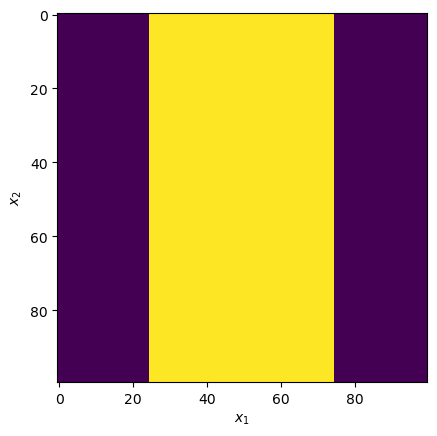

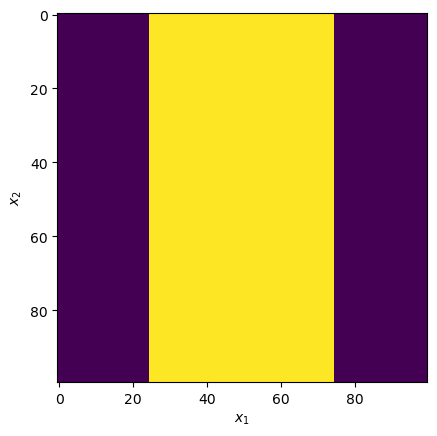

In [896]:
plot_xy(eta.reshape(n_2, n_1, n_3).real, grid)
plot_xy(eta.reshape(n_2, n_1, n_3).imag, grid)

In [897]:
# Внешняя волна, определенная в точках сетки
f_wave = wave(grid, **problem_config)
power_f = np.sum(np.abs(f_wave))/f_wave.size

print("Количество значений на сетке", f_wave.shape)
print("Мощность волны", power_f)

Количество значений на сетке (1000000,)
Мощность волны 1.0


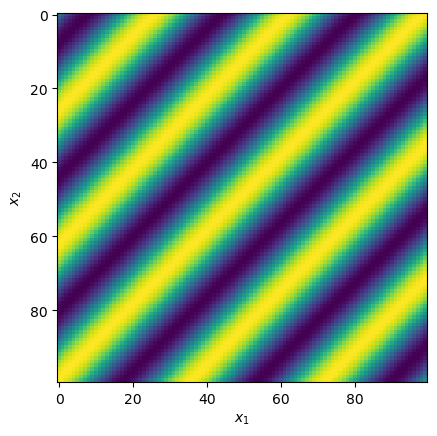

In [898]:
plot_xy(f_wave.reshape(n_2, n_1, n_3).real, grid)

In [899]:
# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))
dists[0] = 10e-8
dists

array([1.00000000e-07, 2.00000000e-02, 4.00000000e-02, ...,
       3.40652315e+00, 3.41795260e+00, 3.42946060e+00])

In [900]:
# Заполнение первой строки матрицы 
G_array = kernel(dists, **problem_config) * volume
G_array[0] = 0
G_array

array([0.00000000e+00+0.00000000e+00j, 3.04093049e-05+9.40670033e-06j,
       1.31356243e-05+8.98656407e-06j, ...,
       1.25796029e-07+1.38204380e-07j, 1.00038093e-07+1.57112338e-07j,
       7.13249624e-08+1.71383258e-07j])

In [901]:
# # Массив ядра интегрального уравнения
# prep_fourier_oper = prep_fftbbtensor(G_array, G_array, n=n_1, m=n_2, k=n_3)
# # Массив комплексно-сопряженных значений ядра интегрального уравнения
# prep_conj_oper = prep_fftbbtensor(np.conj(G_array), np.conj(G_array), n_1, n_2, n_3)

In [917]:
# Умножение внешней волны на ядро оператора
u0_array = fast_bbtmv_mul(G_array.reshape(n_2, n_1, n_3), 
                          G_array.reshape(n_2, n_1, n_3), 
                          f_wave.reshape(n_2, n_1, n_3), 
                          n_2, n_1, n_3).reshape(-1, )

In [918]:
np.sum(np.abs(u0_array))/u0_array.size

0.029903422172524133

In [919]:
plot_xy(u0_array.real, grid)

IndexError: tuple index out of range

In [920]:
# GMRES
result, iters = gmres(G_array, u0_array, eta - 1.0, n_2, n_1, n_3)

Итерация №1: умножений М-В L = 1,
 умножений В-В V = 1,
 невязка resid = 0.06973456

Итерация №2: умножений М-В L = 2,
 умножений В-В V = 3,
 невязка resid = 0.00147634

Итерация №3: умножений М-В L = 3,
 умножений В-В V = 6,
 невязка resid = 4.758e-05

Итерация №4: умножений М-В L = 4,
 умножений В-В V = 10,
 невязка resid = 2.03e-06

Итерация №5: умножений М-В L = 5,
 умножений В-В V = 15,
 невязка resid = 6e-08

Итерация №6: умножений М-В L = 6,
 умножений В-В V = 21,
 невязка resid = 0.0



In [921]:
np.sum(np.abs(result))/result.size

0.0022124849772103597

In [922]:
# result_BICGStab, iters_BICGStab, accuracy_iters_BICGStab, resid_iters_BICGStab = \
# BiCGStab_nu(matrix_A=prep_fourier_oper, vector_f=f_wave, vector_nu=eta - 1.0, vector_u0=None, n=n_1, m=n_2, k=n_3)

result_BICGStab, iters_BICGStab = bicgstab(G_array, u0_array, eta-1, vector_u0=None, n_1=n_2, n_2=n_1, n_3=n_3, tol=1e-8, max_iter=1000)

In [923]:
np.sum(np.abs(result_BICGStab))/result_BICGStab.size

0.028657331314214475

In [924]:
result_TS, iterations_TS, accuracy_TS, resid_TS = \
TwoStep(G_array, 
        np.conj(G_array), 
        u0_array, 
        eta-1, 
        z_0=None, 
        n_1=n_2, n_2=n_1, n_3=n_3, 
        rtol=10e-8, max_iter=None)

Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.9303850212626016
Итерация №2: Умножений М-В L = 6, Умножений В-В V = 8, Критерий останова eps = 0.1212626327207459
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 12, Критерий останова eps = 0.01122539235740664
Итерация №4: Умножений М-В L = 12, Умножений В-В V = 16, Критерий останова eps = 0.0010646541517275083
Итерация №5: Умножений М-В L = 15, Умножений В-В V = 20, Критерий останова eps = 9.5052707247825e-05
Итерация №6: Умножений М-В L = 18, Умножений В-В V = 24, Критерий останова eps = 8.603735935090383e-06
Итерация №7: Умножений М-В L = 21, Умножений В-В V = 28, Критерий останова eps = 7.868946595409974e-07
Итерация №8: Умножений М-В L = 24, Умножений В-В V = 32, Критерий останова eps = 7.064434482113593e-08


In [925]:
np.sum(np.abs(result_TS))/result_TS.size

0.028657331303796087

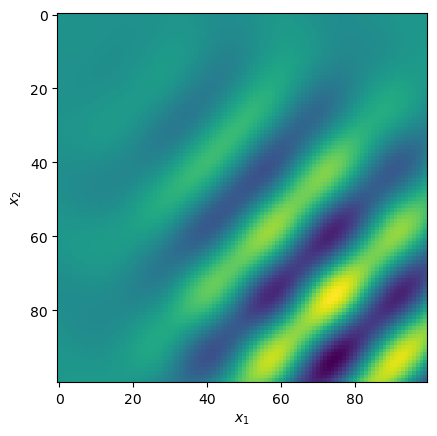

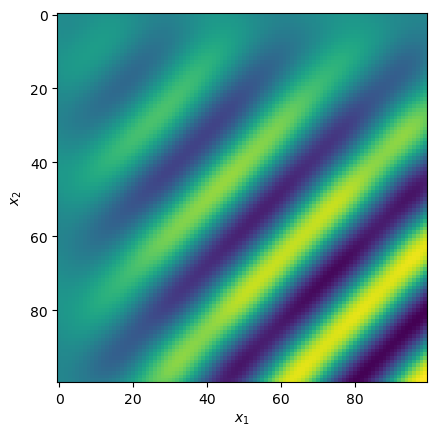

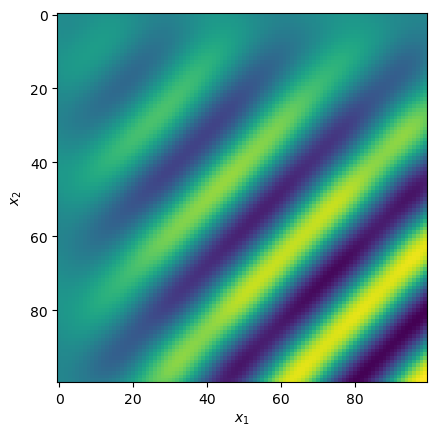

In [926]:
plot_xy(result.reshape(n_2, n_1, n_3).real, grid)
plot_xy(result_TS.reshape(n_2, n_1, n_3).real, grid)
plot_xy(result_BICGStab.reshape(n_2, n_1, n_3).real, grid)

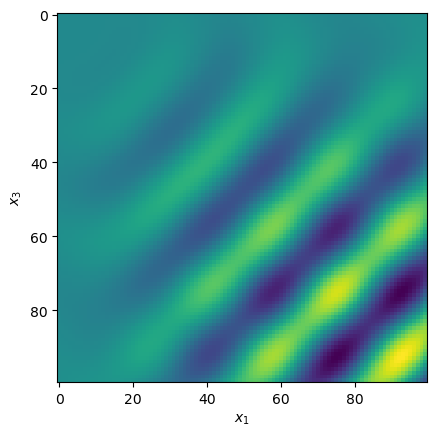

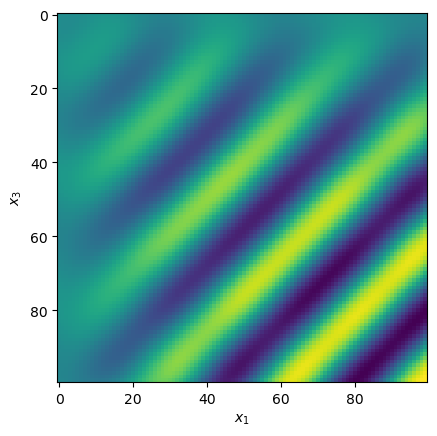

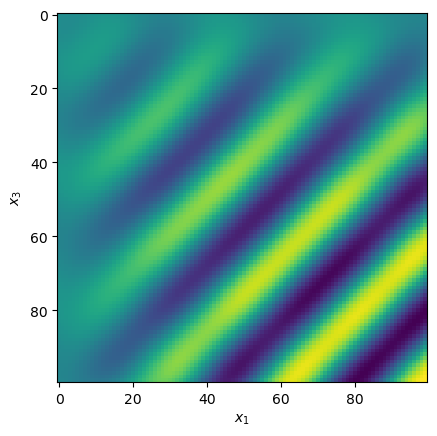

In [927]:
plot_xz(result.reshape(n_2, n_1, n_3).real, grid)
plot_xz(result_TS.reshape(n_2, n_1, n_3).real, grid)
plot_xz(result_BICGStab.reshape(n_2, n_1, n_3).real, grid)

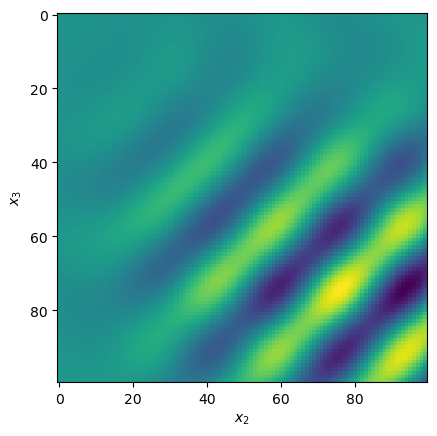

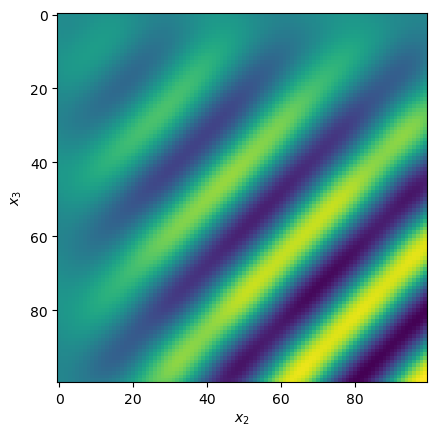

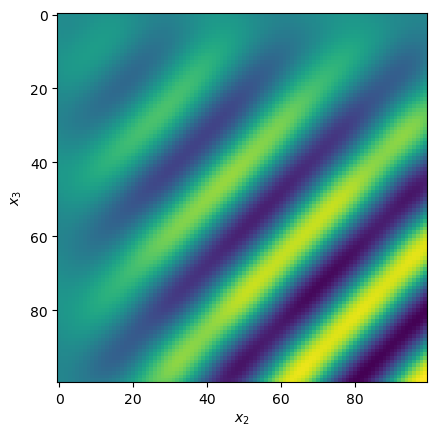

In [928]:
plot_yz(result.reshape(n_2, n_1, n_3).real, grid)
plot_yz(result_TS.reshape(n_2, n_1, n_3).real, grid)
plot_yz(result_BICGStab.reshape(n_2, n_1, n_3).real, grid)

In [932]:
resid_gmres = operator(G_array, result, eta-1, n_2, n_1, n_3) - u0_array
resid_bicgstab = operator(G_array, result_BICGStab, eta-1, n_2, n_1, n_3) - u0_array
resid_ts = operator(G_array, result_TS, eta-1, n_2, n_1, n_3) - u0_array

print('Норма невязки интеграла для GMRES:', bicg_norm(resid_gmres))
print('Норма невязки интеграла для BICGStab:', bicg_norm(resid_bicgstab))
print('Норма невязки интеграла для TwoStep:', bicg_norm(resid_ts))

Норма невязки интеграла для GMRES: (38.36715632894091+0j)
Норма невязки интеграла для BICGStab: (6.55508874819487e-09+0j)
Норма невязки интеграла для TwoStep: (2.346635234927573e-07+0j)


In [934]:
np.mean(np.abs((u0_array - result_BICGStab)))

0.0022154438692207515